El objetivo de esta práctica es observar cómo funcionan las reglas de asociación y para ello vamos a programar una versión en Python del ejemplo [Grocery](https://www.analytics-tuts.com/association-rules-in-r/) en R.

Para empezar, necesitamos instalar las librerías mlxtend, para obtener las reglas en si, y netwotkc, para visualizarlas.

In [1]:
!pip install mlxtend
!pip install networkx

A continuación, cargaremos las librerías necesarias y también el dataset de transacciones que vamos a utilizar. Este dataset es texto plano, con una línea por cada transacción registrada, como por ejemplo:

citrus fruit,semi-finished bread,margarine,ready soups

tropical fruit,yogurt,coffee

whole milk

pip fruit,yogurt,cream cheese ,meat spreads

Para cargarlo, lo leeremos como texto plano y después lo transformaremos en una lista de transacciones a partir de los cambios de línea.


In [2]:
import pandas as pd
import requests
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# Cargar el dataset desde GitHub
url = 'https://raw.githubusercontent.com/crisurdiales/DataMining4SmartCities/main/groceries.csv'
response = requests.get(url)
data = response.text

# Convertir los datos a una lista de transacciones
transactions = [line.split(',') for line in data.split('\n') if line]

#comprobar que ya tenemos formato lista, imprimiendo, por ejemplo, la transacción 3
print(transactions[3])

['pip fruit', 'yogurt', 'cream cheese ', 'meat spreads']


Para trabajar con las transacciones, necesitamos transformarlas a una matriz binaria, esto es cada fila tendrá tantas columnas como items distintos haya en el total del dataset e indicaremos para la fila si en esa transacción había o no había incluido el item de la columna en cuestión (True/False). Dado que tenemos 9835 items distintos y 169 transacciones, df_encoded debe tener 9835x169.

In [3]:
# Usar TransactionEncoder para transformar los datos a una matriz binaria
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)
print(df_encoded.head())

   Instant food products  UHT-milk  abrasive cleaner  artif. sweetener  \
0                  False     False             False             False   
1                  False     False             False             False   
2                  False     False             False             False   
3                  False     False             False             False   
4                  False     False             False             False   

   baby cosmetics  baby food   bags  baking powder  bathroom cleaner   beef  \
0           False      False  False          False             False  False   
1           False      False  False          False             False  False   
2           False      False  False          False             False  False   
3           False      False  False          False             False  False   
4           False      False  False          False             False  False   

   ...  turkey  vinegar  waffles  whipped/sour cream  whisky  white bread  \
0  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Podemos observar cuales son los items aislados más comunes en el dataset, que serán probablemente los que más se repitan en la mayoría de las transacciones.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


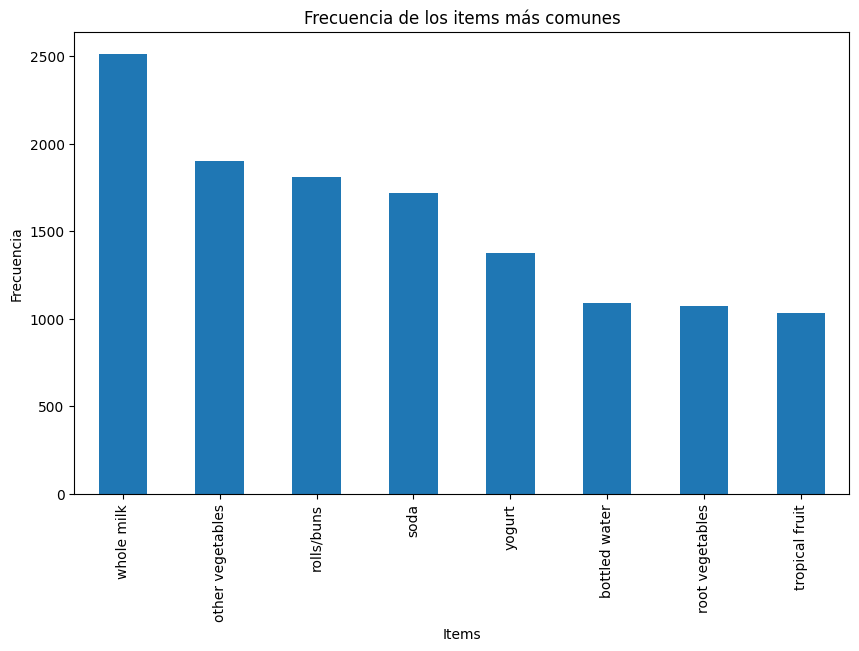

In [4]:
# Graficar la frecuencia de los items más comunes
item_freq = df_encoded.sum().sort_values(ascending=False)
item_freq = item_freq[item_freq > (0.1 * len(df_encoded))]
item_freq.plot(kind='bar', figsize=(10, 6))
plt.title('Frecuencia de los items más comunes')
plt.xlabel('Items')
plt.ylabel('Frecuencia')
plt.show()

Ahora podemos obtener los denominados "ítems frecuentes", que son los conjuntos de ítems (no necesariamente items individuales) que aparecen en al menos en un porcentaje mínimo de transacciones (especificado en el contexto como min_support). Estos conjuntos de ítems frecuentes se representan junto con su soporte, que indica cómo de frecuentemente aparecen en el conjunto de datos. Por ejemplo, en nuestro caso hay 1001 conjuntos.

In [5]:
# Generar los itemsets frecuentes
frequent_itemsets = apriori(df_encoded, min_support=0.005, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La función association_rules puede emplear estos items frecuentes para obtener las reglas de asociación deseadas. Se puede emplear como parátro metric tanto confidence como cualquiera de los habituales:
* Confidence: Mide qué tan probable es que ocurra el consecuente dado el antecedente en las transacciones del conjunto de datos.
* Lift: Mide cuánto más probable es que ocurra la combinación de los antecedentes y los consecuentes juntos frente a que aparezcan de forma independiente.
* Support: Mide la proporción de transacciones en las que aparece un conjunto de ítems dado.
* Leverage: Mide cuánto más frecuente es la ocurrencia conjunta de los antecedentes y los consecuentes que lo que se esperaría si fueran independientes. Es similar al lift, pero no está normalizado por la frecuencia general de los ítems.
* Conviction: Mide cuánto más probable es que ocurra el antecedente sin el consecuente si los antecedentes y los consecuentes son independientes.

Las reglas se estructuran en un dataframe de 10 columnas donde los campos que definen la regla en si son antecendents y consequents (también denominados lhr y rhr). La idea que se transmite es que si aparece en la cesta de la compra el antecedente, probablemente también aparezca el consecuente (en el ejemplo del head(), si se compra leche, también se suele comprar agua embotellada). Es importante recordar que la regla inversa no tiene por qué se cierta (salvo que aparezca como una regla distinta en el conjunto). El dataframe también incluye los parámetros indicados y también la métrica de Zhang,q que combina tanto el lift como la confianza en un solo valor. Esta métrica ayuda a identificar las reglas de asociación que tienen un alto valor de lift y una alta confianza, lo que significa que son tanto significativas como fuertes en términos de asociación entre los antecedentes y los consecuentes.

In [6]:
# Generar las reglas de asociación
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.2)
# Mostrar las reglas
print(rules.head(10))

       antecedents         consequents  antecedent support  \
0       (UHT-milk)     (bottled water)            0.033452   
1       (UHT-milk)  (other vegetables)            0.033452   
2       (UHT-milk)              (soda)            0.033452   
3       (UHT-milk)            (yogurt)            0.033452   
4  (baking powder)  (other vegetables)            0.017692   
5  (baking powder)        (whole milk)            0.017692   
6           (beef)  (other vegetables)            0.052466   
7           (beef)        (rolls/buns)            0.052466   
8           (beef)   (root vegetables)            0.052466   
9           (beef)        (whole milk)            0.052466   

   consequent support   support  confidence      lift  leverage  conviction  \
0            0.110524  0.007321    0.218845  1.980074  0.003624    1.138668   
1            0.193493  0.008134    0.243161  1.256694  0.001662    1.065626   
2            0.174377  0.007626    0.227964  1.307301  0.001793    1.069409   
3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Las reglas se pueden mostrar ordenadas de acuerdo al parámetro que prefiramos y en orden ascendente o descendente.

In [7]:
# Ordenar por confianza
rules_sorted_by_confidence = rules.sort_values(by='confidence', ascending=False)
print(rules_sorted_by_confidence.head(10))

# Ordenar por lift
rules_sorted_by_lift = rules.sort_values(by='zhangs_metric', ascending=False)
print(rules_sorted_by_lift.head(10))

                                        antecedents         consequents  \
888       (root vegetables, yogurt, tropical fruit)        (whole milk)   
841  (root vegetables, pip fruit, other vegetables)        (whole milk)   
374                    (whipped/sour cream, butter)        (whole milk)   
726                 (whipped/sour cream, pip fruit)        (whole milk)   
377                                (yogurt, butter)        (whole milk)   
370                       (root vegetables, butter)        (whole milk)   
453                          (tropical fruit, curd)        (whole milk)   
828     (citrus fruit, root vegetables, whole milk)  (other vegetables)   
847           (yogurt, pip fruit, other vegetables)        (whole milk)   
475                      (pip fruit, domestic eggs)        (whole milk)   

     antecedent support  consequent support   support  confidence      lift  \
888            0.008134            0.255516  0.005694    0.700000  2.739554   
841            0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


También podemos filtrar las reglas por items determinados si lo deseamos, como en cualquer dataframe. Por ejemplo, podemos buscar las reglas en que soda figura en el antecendente de la forma siguiente.

In [8]:
# Filtrar reglas donde el antecedente (lhs) es 'soda'
rules_soda = rules[rules['antecedents'].apply(lambda x: 'soda' in x)]
rules_soda_sorted_by_lift = rules_soda.sort_values(by='lift', ascending=False)
print(rules_soda_sorted_by_lift)

                       antecedents         consequents  antecedent support  \
280           (bottled beer, soda)     (bottled water)            0.016980   
746             (rolls/buns, soda)           (sausage)            0.038332   
294  (fruit/vegetable juice, soda)     (bottled water)            0.018404   
796          (shopping bags, soda)           (sausage)            0.024606   
327                 (yogurt, soda)     (bottled water)            0.027351   
795                (sausage, soda)     (shopping bags)            0.024301   
652       (soda, other vegetables)           (sausage)            0.032740   
705             (whole milk, soda)            (pastry)            0.040061   
634       (soda, other vegetables)   (root vegetables)            0.032740   
813                 (yogurt, soda)    (tropical fruit)            0.027351   
635        (root vegetables, soda)  (other vegetables)            0.018607   
814         (tropical fruit, soda)            (yogurt)          

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Finalmente, podemos graficar los resultados, aunque cuando el conjunto de reglas es muy grande, la representación es ilegible. Por eso, nos limitarlemos a las 10 reglas más importantes en términos de lift.

In [9]:
# Filtrar las 10 reglas con mayor lift
top_10_lift_rules = rules.nlargest(10, 'lift')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


El código a continuación representa los antecendentes ligados por una flecha a los consecuentes, donde cada flecha indica el lift de la transacción. Si se prefiere, podría representarse el lift como el grosor de las flechas, añadiedo la línea  norm_lift = rule['lift'] / max_lift,  y en G.add_edge(antecedent, consequent, weight=norm_lift)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-10-3dd52136ba86>:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


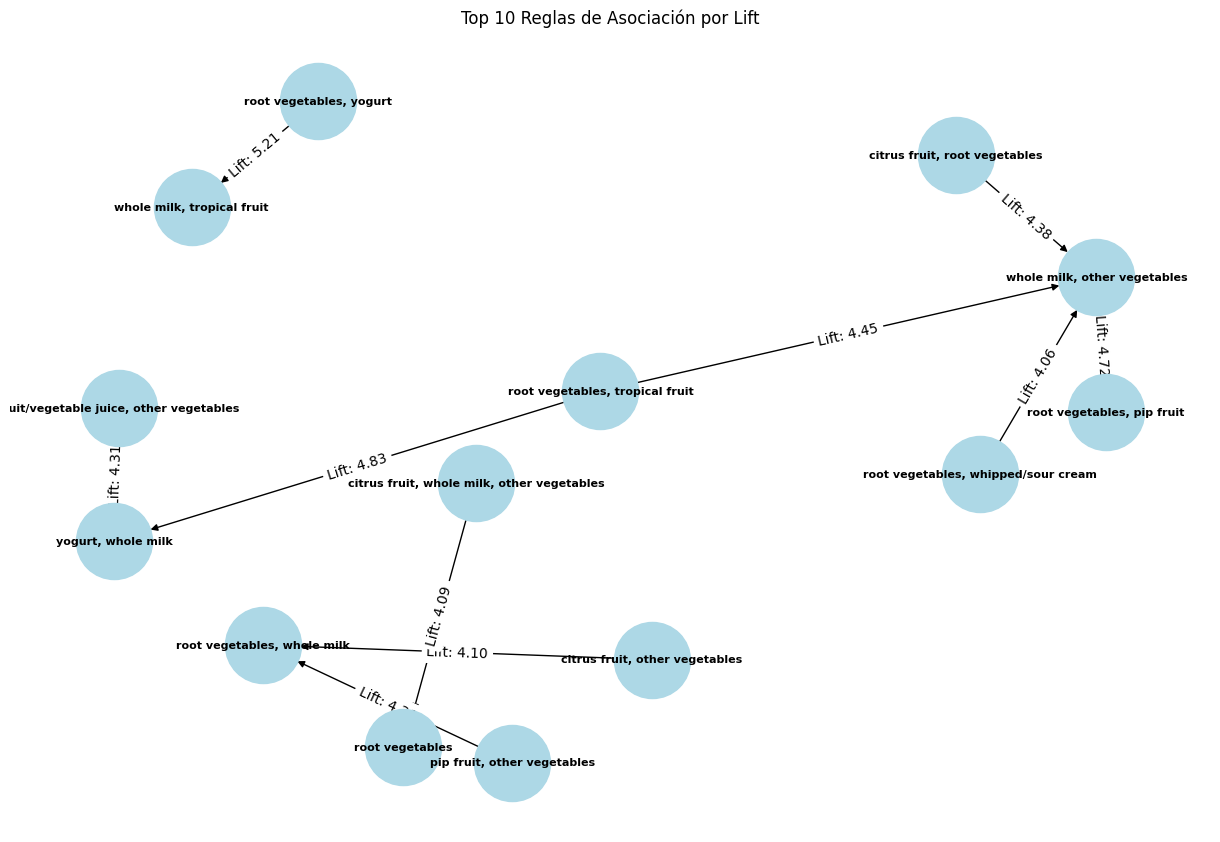

In [10]:
import networkx as nx


# Crear un gráfico dirigido
G = nx.DiGraph()

# Agregar nodos y aristas a la red para las 10 reglas
for _, rule in top_10_lift_rules.iterrows():
    antecedent = ', '.join(rule['antecedents'])
    consequent = ', '.join(rule['consequents'])
    G.add_edge(antecedent, consequent, weight=rule['lift'])

# Dibujar la red
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=1.5)  # Definir la disposición de los nodos
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=8, font_weight='bold')  # Dibujar nodos
nx.draw_networkx_edge_labels(G, pos, font_size=10, edge_labels={(u, v): f"Lift: {d['weight']:.2f}" for u, v, d in G.edges(data=True)})  # Etiquetas de las aristas con el valor del lift
plt.title('Top 10 Reglas de Asociación por Lift')
plt.tight_layout()
plt.show()